In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from sequence_logo_helper_protein import plot_protein_logo

import pandas as pd

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

class EpochVariableCallback(Callback) :
    
    def __init__(self, my_variable, my_func) :
        self.my_variable = my_variable       
        self.my_func = my_func
        
    def on_epoch_begin(self, epoch, logs={}) :
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))


class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            val : key for key, val in channel_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            if max_nt == 1 :
                seq += self.decode_map[argmax_nt]
            else :
                seq += self.decode_map[-1]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        encoding = np.array(encoding_mat[row_index, :].todense()).reshape(-1, 4)
        return self.decode(encoding)

class NopTransformer(iso.ValueTransformer) :
    
    def __init__(self, n_classes) :
        super(NopTransformer, self).__init__('nop', (n_classes, ))
        
        self.n_classes = n_classes
    
    def transform(self, values) :
        return values
    
    def transform_inplace(self, values, transform) :
        transform[:] = values
    
    def transform_inplace_sparse(self, values, transform_mat, row_index) :
        transform_mat[row_index, :] = np.ravel(values)


Using TensorFlow backend.


In [2]:
#Re-load cached dataframe (shuffled)

dataset_name = "coiled_coil_binders"

experiment = "baker_big_set_5x_negatives"

pair_df = pd.read_csv("pair_df_" + experiment + "_in_shuffled.csv", sep="\t")

print("len(pair_df) = " + str(len(pair_df)))

print(pair_df.head())

#Generate training and test set indexes
valid_set_size = 0.0005
test_set_size = 0.0995

data_index = np.arange(len(pair_df), dtype=np.int)

train_index = data_index[:-int(len(pair_df) * (valid_set_size + test_set_size))]
valid_index = data_index[train_index.shape[0]:-int(len(pair_df) * test_set_size)]
test_index = data_index[train_index.shape[0] + valid_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Validation set size = ' + str(valid_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


len(pair_df) = 890124
   Unnamed: 0                                       monomer_id_1  \
0           0  redesigned_closed_6_6_9_9middlesbobby_1_4_S_01...   
1           1  redesigned_closed_6_8_9_9middlesbobby_1_4_S_40...   
2           2  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   
3           3  redesigned_closed_5_7_9_9middlesbobby_1_1_S_43...   
4           4  redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...   

                                        monomer_id_2  \
0  redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...   
1  redesigned_closed_5_7_8_10middlesbobby_1_2_S_0...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
3  redesigned_closed_5_6_9_9middlesbobby_1_1_S_25...   
4  redesigned_closed_6_6_8_9middlesbobby_1_5_S_16...   

                                         amino_seq_1  \
0  SEKDLLRLNREILEEIERIQKDLEELLERAERDAEGGLEELEKLVR...   
1  SEKEVMKEQIRLIRENIKAQEEILRLLKELERKGVDKEVEEVIKRI...   
2  DEEEILKILEENLRIQREIDRIHEEQVKALERITRRREDREEIEKL...   
3  STEDI

In [3]:
#Sub-select smaller dataset

n_train_pos = 20000
n_train_neg = 20000

n_test_pos = 2000
n_test_neg = 2000

orig_n_train = train_index.shape[0]
orig_n_valid = valid_index.shape[0]
orig_n_test = test_index.shape[0]

train_index_pos = np.nonzero((pair_df.iloc[train_index]['interacts'] == 1).values)[0][:n_train_pos]
train_index_neg = np.nonzero((pair_df.iloc[train_index]['interacts'] == 0).values)[0][:n_train_neg]

train_index = np.concatenate([train_index_pos, train_index_neg], axis=0)
np.random.shuffle(train_index)

test_index_pos = np.nonzero((pair_df.iloc[test_index]['interacts'] == 1).values)[0][:n_test_pos] + orig_n_train + orig_n_valid
test_index_neg = np.nonzero((pair_df.iloc[test_index]['interacts'] == 0).values)[0][:n_test_neg] + orig_n_train + orig_n_valid

test_index = np.concatenate([test_index_pos, test_index_neg], axis=0)
np.random.shuffle(test_index)

print('Training set size = ' + str(train_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


Training set size = 40000
Test set size = 4000


In [4]:
#Calculate sequence lengths

pair_df['amino_seq_1_len'] = pair_df['amino_seq_1'].str.len()
pair_df['amino_seq_2_len'] = pair_df['amino_seq_2'].str.len()


In [5]:
pair_df.head()

,Unnamed: 0,monomer_id_1,monomer_id_2,amino_seq_1,amino_seq_2,interacts,amino_seq_1_len,amino_seq_2_len
0,0,redesigned_closed_6_6_9_9middlesbobby_1_4_S_01...,redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...,SEKDLLRLNREILEEIERIQKDLEELLERAERDAEGGLEELEKLVR...,TSEENVERQREHVRTTDEAIKEMEKIIRLLEVVARGEMDRDELRKV...,0.0,70,76
1,1,redesigned_closed_6_8_9_9middlesbobby_1_4_S_40...,redesigned_closed_5_7_8_10middlesbobby_1_2_S_0...,SEKEVMKEQIRLIRENIKAQEEILRLLKELERKGVDKEVEEVIKRI...,STEEVERIVEEVERISRRVVEISRRVVEKIRELIRRMKNERLVELL...,0.0,68,75
2,2,redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...,redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...,DEEEILKILEENLRIQREIDRIHEEQVKALERITRRREDREEIEKL...,RTRELLDEHRKLLEEQERQTKQDEELLREVERRLREELIEMAKDVQ...,0.0,76,68
3,3,redesigned_closed_5_7_9_9middlesbobby_1_1_S_43...,redesigned_closed_5_6_9_9middlesbobby_1_1_S_25...,STEDIARELRKIIRRDKESKKEIKRVHDEQRELAKDAEDSRVVRRL...,GKEEVLEVAKRLLELQEKLQRLHEELQRILDDIVRRKNADDTLVRR...,0.0,76,73
4,4,redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...,redesigned_closed_6_6_8_9middlesbobby_1_5_S_16...,SEKEIIKRLNKLNEDLTRLLETYRRLVEEVERAGALEEELRRRQRE...,SEKEELKRLLEESNKLLELVKEQLRLAEDALRKIAKKARGEVEILE...,0.0,70,77


In [6]:
#Initialize sequence encoder

seq_length = 81

residue_map = {'D': 0, 'E': 1, 'V': 2, 'K': 3, 'R': 4, 'L': 5, 'S': 6, 'T': 7, 'N': 8, 'H': 9, 'A': 10, 'I': 11, 'G': 12, 'P': 13, 'Q': 14, 'Y': 15, 'W': 16, 'M': 17, 'F': 18, '#': 19}

encoder = IdentityEncoder(seq_length, residue_map)


In [7]:
#Construct data generators

class CategoricalRandomizer :
    
    def __init__(self, case_range, case_probs) :
        self.case_range = case_range
        self.case_probs = case_probs
        self.cases = 0
        
    def get_random_sample(self, index=None) :
        if index is None :
            return self.cases
        else :
            return self.cases[index]
    
    def generate_random_sample(self, batch_size=1, data_ids=None) :
        self.cases = np.random.choice(self.case_range, size=batch_size, replace=True, p=self.case_probs)

def get_amino_seq(row, index, flip_randomizer, homodimer_randomizer, max_seq_len=seq_length) :
    
    is_flip = True if flip_randomizer.get_random_sample(index=index) == 1 else False
    is_homodimer = True if homodimer_randomizer.get_random_sample(index=index) == 1 else False
    
    amino_seq_1, amino_seq_2 = row['amino_seq_1'], row['amino_seq_2']
    if is_flip :
        amino_seq_1, amino_seq_2 = row['amino_seq_2'], row['amino_seq_1']
    if is_homodimer and row['interacts'] < 0.5 :
        amino_seq_2 = amino_seq_1
    
    return amino_seq_1, amino_seq_2

flip_randomizer = CategoricalRandomizer(np.arange(2), np.array([0.5, 0.5]))
homodimer_randomizer = CategoricalRandomizer(np.arange(2), np.array([0.95, 0.05]))

batch_size = 32

data_gens = {
    gen_id : iso.DataGenerator(
        idx,
        { 'df' : pair_df },
        batch_size=(idx.shape[0] // batch_size) * batch_size,
        inputs = [
            {
                'id' : 'amino_seq_1',
                'source_type' : 'dataframe',
                'source' : 'df',
                #'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: (get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0] + "#" * seq_length)[:seq_length],
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0],
                'encoder' : IdentityEncoder(seq_length, residue_map),
                'dim' : (1, seq_length, len(residue_map)),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_2',
                'source_type' : 'dataframe',
                'source' : 'df',
                #'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: (get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1] + "#" * seq_length)[:seq_length],
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1],
                'encoder' : IdentityEncoder(seq_length, residue_map),
                'dim' : (1, seq_length, len(residue_map)),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_1_len',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: len(get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0]),
                'encoder' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_2_len',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: len(get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1]),
                'encoder' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'interacts',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['interacts'],
                'transformer' : NopTransformer(1),
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [flip_randomizer, homodimer_randomizer],
        shuffle = True
    ) for gen_id, idx in [('train', train_index), ('valid', valid_index), ('test', test_index)]
}


In [8]:
#Load data matrices

[x_1_train, x_2_train, l_1_train, l_2_train], [y_train] = data_gens['train'][0]
[x_1_test, x_2_test, l_1_test, l_2_test], [y_test] = data_gens['test'][0]

print("x_1_train.shape = " + str(x_1_train.shape))
print("x_2_train.shape = " + str(x_2_train.shape))
print("x_1_test.shape = " + str(x_1_test.shape))
print("x_2_test.shape = " + str(x_2_test.shape))

print("l_1_train.shape = " + str(l_1_train.shape))
print("l2_train.shape = " + str(l_2_train.shape))
print("l_1_test.shape = " + str(l_1_test.shape))
print("l2_test.shape = " + str(l_2_test.shape))

print("y_train.shape = " + str(y_train.shape))
print("y_test.shape = " + str(y_test.shape))


x_1_train.shape = (40000, 1, 81, 20)
x_2_train.shape = (40000, 1, 81, 20)
x_1_test.shape = (4000, 1, 81, 20)
x_2_test.shape = (4000, 1, 81, 20)
l_1_train.shape = (40000, 1)
l2_train.shape = (40000, 1)
l_1_test.shape = (4000, 1)
l2_test.shape = (4000, 1)
y_train.shape = (40000, 1)
y_test.shape = (4000, 1)


In [9]:
#Define sequence templates

sequence_templates = [
    '$' * i + '@' * (seq_length - i)
    for i in range(seq_length+1)
]

sequence_masks = [
    np.array([1 if sequence_templates[i][j] == '$' else 0 for j in range(len(sequence_templates[i]))])
    for i in range(seq_length+1)
]


In [10]:
#Calculate background distributions

pseudo_count = 0.1

x_means = []
x_mean_logits = []
for i in range(seq_length + 1) :
    x_train_len = x_1_train[np.ravel(l_1_train) == i, ...]
    
    if x_train_len.shape[0] > 0 :
        x_mean_len = (np.sum(x_train_len, axis=(0, 1)) + pseudo_count) / (np.sum(x_train_len, axis=(0, 1, 3)).reshape(-1, 1) + 20. * pseudo_count)
        x_mean_logits_len = np.log(x_mean_len)
        
        x_means.append(x_mean_len)
        x_mean_logits.append(x_mean_logits_len)
    else :
        x_means.append(np.zeros((x_1_train.shape[2], x_1_train.shape[3])))
        x_mean_logits.append(np.zeros((x_1_train.shape[2], x_1_train.shape[3])))


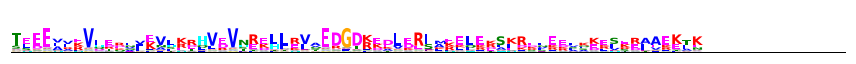

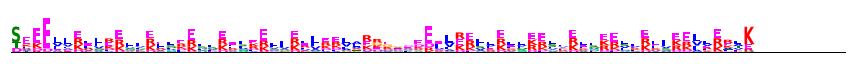

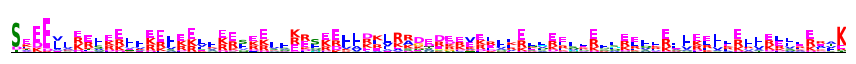

In [11]:
#Visualize a few background sequence distributions

visualize_len = 67

plot_protein_logo(residue_map, np.copy(x_means[visualize_len]), sequence_template=sequence_templates[visualize_len], figsize=(12, 1), logo_height=1.0, plot_start=0, plot_end=81)

visualize_len = 72

plot_protein_logo(residue_map, np.copy(x_means[visualize_len]), sequence_template=sequence_templates[visualize_len], figsize=(12, 1), logo_height=1.0, plot_start=0, plot_end=81)

visualize_len = 81

plot_protein_logo(residue_map, np.copy(x_means[visualize_len]), sequence_template=sequence_templates[visualize_len], figsize=(12, 1), logo_height=1.0, plot_start=0, plot_end=81)


In [11]:
#Calculate mean training set kl-divergence against background

mean_kl_divs = []

for i in range(seq_length + 1) :
    x_train_len = x_1_train[np.ravel(l_1_train) == i, ...]
    
    if x_train_len.shape[0] > 0 :
        x_train_clipped_len = np.clip(np.copy(x_train_len[:, 0, :, :]), 1e-8, 1. - 1e-8)

        kl_divs = np.sum(x_train_clipped_len * np.log(x_train_clipped_len / np.tile(np.expand_dims(x_means[i], axis=0), (x_train_clipped_len.shape[0], 1, 1))), axis=-1) / np.log(2.0)

        x_mean_kl_divs = np.sum(kl_divs * sequence_masks[i], axis=-1) / np.sum(sequence_masks[i])
        x_mean_kl_div = np.mean(x_mean_kl_divs)

        mean_kl_divs.append(x_mean_kl_div)
        
        print("[Length = " + str(i) + "] Mean KL Div against background (bits) = " + str(x_mean_kl_div))
    else :
        mean_kl_divs.append(0)


[Length = 67] Mean KL Div against background (bits) = 1.8953373401017208
[Length = 68] Mean KL Div against background (bits) = 2.5463560887672436
[Length = 69] Mean KL Div against background (bits) = 2.6994657310708723
[Length = 70] Mean KL Div against background (bits) = 2.6109095879087394
[Length = 71] Mean KL Div against background (bits) = 2.640706513669912
[Length = 72] Mean KL Div against background (bits) = 2.692499723381437
[Length = 73] Mean KL Div against background (bits) = 2.6626426023568674
[Length = 74] Mean KL Div against background (bits) = 2.7341044920450828
[Length = 75] Mean KL Div against background (bits) = 2.610516567707057
[Length = 76] Mean KL Div against background (bits) = 2.6658032296120617
[Length = 77] Mean KL Div against background (bits) = 2.677352850205842
[Length = 78] Mean KL Div against background (bits) = 2.648193313243239
[Length = 79] Mean KL Div against background (bits) = 2.6336034167151596
[Length = 80] Mean KL Div against background (bits) = 2.

In [12]:

#Gumbel Distribution Sampler
def gumbel_softmax(logits, temperature=0.5) :
    gumbel_dist = tf.contrib.distributions.RelaxedOneHotCategorical(temperature, logits=logits)
    batch_dim = logits.get_shape().as_list()[0]
    onehot_dim = logits.get_shape().as_list()[1]
    return gumbel_dist.sample()

def sample_mask_gumbel(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 2))
    sampled_pwm = gumbel_softmax(flat_pwm, temperature=0.5)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 2))[..., :1]


In [21]:
#PWM Masking and Sampling helper functions

def mask_pwm(inputs) :
    pwm, onehot_template, onehot_mask = inputs

    return pwm * onehot_mask + onehot_template

#Generator helper functions
def initialize_sequence_templates(generator, encoder, sequence_templates, background_matrices) :

    embedding_templates = []
    embedding_masks = []
    embedding_backgrounds = []

    for k in range(len(sequence_templates)) :
        sequence_template = sequence_templates[k]
        onehot_template = encoder(sequence_template).reshape((1, len(sequence_template), 20))

        for j in range(len(sequence_template)) :
            if sequence_template[j] not in ['$', '@'] :
                nt_ix = np.argmax(onehot_template[0, j, :])
                onehot_template[:, j, :] = -4.0
                onehot_template[:, j, nt_ix] = 10.0

        onehot_mask = np.zeros((1, len(sequence_template), 20))
        for j in range(len(sequence_template)) :
            if sequence_template[j] == '$' :
                onehot_mask[:, j, :] = 1.0

        embedding_templates.append(onehot_template.reshape(1, -1))
        embedding_masks.append(onehot_mask.reshape(1, -1))
        embedding_backgrounds.append(background_matrices[k].reshape(1, -1))

    embedding_templates = np.concatenate(embedding_templates, axis=0)
    embedding_masks = np.concatenate(embedding_masks, axis=0)
    embedding_backgrounds = np.concatenate(embedding_backgrounds, axis=0)

    generator.get_layer('template_dense').set_weights([embedding_templates])
    generator.get_layer('template_dense').trainable = False

    generator.get_layer('mask_dense').set_weights([embedding_masks])
    generator.get_layer('mask_dense').trainable = False
    
    #generator.get_layer('background_dense').set_weights([embedding_backgrounds])
    #generator.get_layer('background_dense').trainable = False

#Generator construction function
def build_sampler(batch_size, seq_length, n_classes=1) :

    #Initialize Reshape layer
    reshape_layer = Reshape((1, seq_length, 20))
    
    #Initialize background matrix
    onehot_background_dense = Embedding(n_classes, seq_length * 20, embeddings_initializer='zeros', name='background_dense')

    #Initialize template and mask matrices
    onehot_template_dense = Embedding(n_classes, seq_length * 20, embeddings_initializer='zeros', name='template_dense')
    onehot_mask_dense = Embedding(n_classes, seq_length * 20, embeddings_initializer='ones', name='mask_dense')

    #Initialize Templating and Masking Lambda layer
    masking_layer = Lambda(mask_pwm, output_shape = (1, seq_length, 20), name='masking_layer')
    
    def _sampler_func(class_input, scaled_pwm) :
        
        #Get Template and Mask
        onehot_background = reshape_layer(onehot_background_dense(class_input))
        onehot_template = reshape_layer(onehot_template_dense(class_input))
        onehot_mask = reshape_layer(onehot_mask_dense(class_input))
        
        #Add Template and Multiply Mask
        pwm = masking_layer([scaled_pwm, onehot_template, onehot_mask])
        
        return pwm, onehot_mask
    
    return _sampler_func


In [22]:
#Scrambler network definition

def make_resblock(n_channels=64, window_size=8, dilation_rate=1, group_ix=0, layer_ix=0, drop_rate=0.0) :

    #Initialize res block layers
    batch_norm_0 = BatchNormalization(name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')

    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_0 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_0')

    batch_norm_1 = BatchNormalization(name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')

    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_1 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

    skip_1 = Lambda(lambda x: x[0] + x[1], name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

    drop_1 = None
    if drop_rate > 0.0 :
        drop_1 = Dropout(drop_rate)
    
    #Execute res block
    def _resblock_func(input_tensor) :
        batch_norm_0_out = batch_norm_0(input_tensor)
        relu_0_out = relu_0(batch_norm_0_out)
        conv_0_out = conv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(conv_0_out)
        relu_1_out = relu_1(batch_norm_1_out)
        
        if drop_rate > 0.0 :
            conv_1_out = drop_1(conv_1(relu_1_out))
        else :
            conv_1_out = conv_1(relu_1_out)

        skip_1_out = skip_1([conv_1_out, input_tensor])
        
        return skip_1_out

    return _resblock_func

def load_scrambler_network(n_groups=1, n_resblocks_per_group=4, n_channels=32, window_size=8, dilation_rates=[1], drop_rate=0.0) :

    #Discriminator network definition
    label_concat = Lambda(lambda x: K.concatenate([x[0], K.tile(K.expand_dims(K.expand_dims(x[1], axis=-1), axis=-1), (1, 1, K.shape(x[0])[2], 1))], axis=-1))
    
    conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_conv_0')
    
    skip_convs = []
    resblock_groups = []
    for group_ix in range(n_groups) :
        
        skip_convs.append(Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_skip_conv_' + str(group_ix)))
        
        resblocks = []
        for layer_ix in range(n_resblocks_per_group) :
            resblocks.append(make_resblock(n_channels=n_channels, window_size=window_size, dilation_rate=dilation_rates[group_ix], group_ix=group_ix, layer_ix=layer_ix, drop_rate=drop_rate))
        
        resblock_groups.append(resblocks)

    last_block_conv = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_last_block_conv')
    
    skip_add = Lambda(lambda x: x[0] + x[1], name='scrambler_skip_add')
    
    final_conv_2_channels = Conv2D(2, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_final_conv')
    
    final_conv_sigm = Lambda(lambda x: K.softmax(x, axis=-1)[..., :1])
    final_conv_gumbel = Lambda(lambda x: sample_mask_gumbel(x))
    
    scale_inputs = Lambda(lambda x: x[1] * K.tile((1. - x[0]), (1, 1, 1, 20)), name='scrambler_input_scale')
    
    def _scrambler_func(sequence_input, label_input) :
        conv_0_out = conv_0(label_concat([sequence_input, label_input]))

        #Connect group of res blocks
        output_tensor = conv_0_out

        #Res block group execution
        skip_conv_outs = []
        for group_ix in range(n_groups) :
            skip_conv_out = skip_convs[group_ix](output_tensor)
            skip_conv_outs.append(skip_conv_out)

            for layer_ix in range(n_resblocks_per_group) :
                output_tensor = resblock_groups[group_ix][layer_ix](output_tensor)
        
        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = last_block_conv_out
        for group_ix in range(n_groups) :
            skip_add_out = skip_add([skip_add_out, skip_conv_outs[group_ix]])

        #Final conv out
        final_conv_2_channels_out = final_conv_2_channels(skip_add_out)
        
        final_conv_sigm_out = final_conv_sigm(final_conv_2_channels_out)
        final_conv_gumbel_out = final_conv_gumbel(final_conv_2_channels_out)
        
        #Scale inputs by importance scores
        scaled_inputs = scale_inputs([final_conv_gumbel_out, sequence_input])
        
        return scaled_inputs, final_conv_sigm_out

    return _scrambler_func


In [23]:
#Keras loss functions

def get_sigmoid_kl_divergence() :

    def _kl_divergence(y_true, y_pred) :

        y_true = K.clip(y_true, K.epsilon(), 1.0 - K.epsilon())
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())

        return K.mean(y_true * K.log(y_true / y_pred) + (1.0 - y_true) * K.log((1.0 - y_true) / (1.0 - y_pred)), axis=-1)
    
    return _kl_divergence

def get_margin_lum_ame_masked(pwm_start, pwm_end) :
    
    def _margin_lum_ame(importance_scores, pwm_mask, max_lum) :
        p_ons = importance_scores[:, 0, pwm_start:pwm_end, 0]
        
        mask = K.max(pwm_mask[:, 0, pwm_start:pwm_end, :], axis=-1)
        n_unmasked = K.sum(mask, axis=-1)
        
        mean_p_on = K.switch(n_unmasked > 0, K.sum(p_ons * mask, axis=-1) / n_unmasked, max_lum[:, 0])

        margin_p_on = K.switch(mean_p_on > max_lum[:, 0], mean_p_on - max_lum[:, 0], K.zeros_like(mean_p_on))
    
        return margin_p_on
    
    return _margin_lum_ame

def get_target_lum_sme_masked(pwm_start, pwm_end) :
    
    def _target_lum_sme(importance_scores, pwm_mask, target_lum) :
        p_ons = importance_scores[:, 0, pwm_start:pwm_end, 0]
        
        mask = K.max(pwm_mask[:, 0, pwm_start:pwm_end, :], axis=-1)
        n_unmasked = K.sum(mask, axis=-1)
        
        mean_p_on = K.switch(n_unmasked > 0, K.sum(p_ons * mask, axis=-1) / n_unmasked, target_lum[:, 0])
        
        return (mean_p_on - target_lum[:, 0])**2
    
    return _target_lum_sme

def get_weighted_loss(loss_coeff=1.) :
    
    def _min_pred(y_true, y_pred) :
        return loss_coeff * y_pred
    
    return _min_pred


In [24]:
#Initialize Encoder and Decoder networks
batch_size = 32
seq_length = 81
n_samples = 32
sample_mode = 'gumbel'

#Resnet parameters
resnet_n_groups = 5
resnet_n_resblocks_per_group = 4
resnet_n_channels = 48
resnet_window_size = 3
resnet_dilation_rates = [1, 2, 4, 2, 1]
resnet_drop_rate = 0.0

#Load scrambler
scrambler = load_scrambler_network(
    n_groups=resnet_n_groups,
    n_resblocks_per_group=resnet_n_resblocks_per_group,
    n_channels=resnet_n_channels, window_size=resnet_window_size,
    dilation_rates=resnet_dilation_rates,
    drop_rate=resnet_drop_rate
)

#Load sampler
sampler = build_sampler(batch_size, seq_length, n_classes=seq_length+1)


In [25]:
#Load predictor

predictor_path = 'saved_models/ppi_rnn_baker_big_set_5x_negatives_classifier_symmetric_drop_25_5x_negatives_balanced_partitioned_data_epoch_10.h5'

predictor = load_model(predictor_path, custom_objects={ 'sigmoid_nll' : get_sigmoid_kl_divergence() })
predictor.trainable = False
predictor.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(lr=0.1))


In [26]:
#Create inverted labels

y_train_inv = 1. - y_train
y_test_inv = 1. - y_test


In [27]:
#Build scrambler model
scrambler_class_1 = Input(shape=(1,), name='scrambler_class_1')
scrambler_input_1 = Input(shape=(1, seq_length, 20), name='scrambler_input_1')
scrambler_class_2 = Input(shape=(1,), name='scrambler_class_2')
scrambler_input_2 = Input(shape=(1, seq_length, 20), name='scrambler_input_2')
scrambler_label = Input(shape=(1,), name='scrambler_label')

scrambler_input_concat = Lambda(lambda x: K.concatenate(x, axis=2))
scrambler_input = scrambler_input_concat([scrambler_input_1, scrambler_input_2])

scrambled_pwm, importance_scores = scrambler(scrambler_input, scrambler_label)

scrambler_split = Lambda(lambda x: [x[:, :, :seq_length, :], x[:, :, seq_length:, :]])
scrambled_pwm_1, scrambled_pwm_2 = scrambler_split(scrambled_pwm)
importance_scores_1, importance_scores_2 = scrambler_split(importance_scores)

pwm_1, pwm_mask_1 = sampler(scrambler_class_1, scrambled_pwm_1)
pwm_2, pwm_mask_2 = sampler(scrambler_class_2, scrambled_pwm_2)

zeropad_layer = Lambda(lambda x: x[0] * x[1], name='zeropad')
sampled_pwm_zeropad_1 = zeropad_layer([pwm_1, pwm_mask_1])
sampled_pwm_zeropad_2 = zeropad_layer([pwm_2, pwm_mask_2])

scrambler_model = Model([scrambler_input_1, scrambler_class_1, scrambler_input_2, scrambler_class_2, scrambler_label], [pwm_1, importance_scores_1, pwm_2, importance_scores_2])

#Initialize Sequence Templates and Masks
initialize_sequence_templates(scrambler_model, encoder, sequence_templates, x_mean_logits)

scrambler_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss='mean_squared_error'
)


In [28]:
#Set target lum

conservation_target_lum = np.zeros(seq_length+1)
conservation_target_lum[:] = 0.1
conservation_target_lum = conservation_target_lum.tolist()

entropy_target_lum = np.zeros(seq_length+1)
entropy_target_lum[:] = 0.1
entropy_target_lum = entropy_target_lum.tolist()


In [29]:
#Helper function for setting sequence-length-specific parameters

def initialize_sequence_length_params(model, background_matrix_list, conservation_target_lum_list, entropy_target_lum_list) :

    flat_background_matrix_list = []
    flat_conservation_target_lum_list = []
    flat_entropy_target_lum_list = []

    for k in range(len(background_matrix_list)) :
        flat_background_matrix_list.append(background_matrix_list[k].reshape(1, -1))
        flat_conservation_target_lum_list.append(np.array([conservation_target_lum_list[k]]).reshape(1, -1))
        flat_entropy_target_lum_list.append(np.array([entropy_target_lum_list[k]]).reshape(1, -1))

    flat_background_matrix_list = np.concatenate(flat_background_matrix_list, axis=0)
    flat_conservation_target_lum_list = np.concatenate(flat_conservation_target_lum_list, axis=0)
    flat_entropy_target_lum_list = np.concatenate(flat_entropy_target_lum_list, axis=0)

    layer_names = [layer.name for layer in model.layers]
    
    if 'x_mean_dense' in layer_names :
        model.get_layer('x_mean_dense').set_weights([flat_background_matrix_list])
        model.get_layer('x_mean_dense').trainable = False

    model.get_layer('conservation_target_lum_dense').set_weights([flat_conservation_target_lum_list])
    model.get_layer('conservation_target_lum_dense').trainable = False
    
    model.get_layer('entropy_target_lum_dense').set_weights([flat_entropy_target_lum_list])
    model.get_layer('entropy_target_lum_dense').trainable = False


In [30]:
#Build Auto-scrambler pipeline

#Define model inputs
ae_scrambler_class_1 = Input(shape=(1,), name='ae_scrambler_class_1')
ae_scrambler_input_1 = Input(shape=(1, seq_length, 20), name='ae_scrambler_input_1')
ae_scrambler_class_2 = Input(shape=(1,), name='ae_scrambler_class_2')
ae_scrambler_input_2 = Input(shape=(1, seq_length, 20), name='ae_scrambler_input_2')
ae_label_input = Input(shape=(1,), name='ae_label_input')
ae_correct_label_input = Input(shape=(1,), name='ae_correct_label_input')

#Run encoder and decoder
scrambler_input_concat = Lambda(lambda x: K.concatenate(x, axis=2))
scrambler_input = scrambler_input_concat([ae_scrambler_input_1, ae_scrambler_input_2])

scrambled_in, importance_scores = scrambler(scrambler_input, ae_correct_label_input)

scrambler_split = Lambda(lambda x: [x[:, :, :seq_length, :], x[:, :, seq_length:, :]])
scrambled_in_1, scrambled_in_2 = scrambler_split(scrambled_in)

scrambler_split_imp_scores = Lambda(lambda x: [x[:, :, :seq_length, :], x[:, :, seq_length:, :]])
importance_scores_1, importance_scores_2 = scrambler_split_imp_scores(importance_scores)

scrambled_pwm_1, pwm_mask_1 = sampler(ae_scrambler_class_1, scrambled_in_1)
scrambled_pwm_2, pwm_mask_2 = sampler(ae_scrambler_class_2, scrambled_in_2)

zeropad_layer_1 = Lambda(lambda x: x[0] * x[1], name='zeropad_1')
zeropad_layer_2 = Lambda(lambda x: x[0] * x[1], name='zeropad_2')
scrambled_pwm_1_zeropad = zeropad_layer_1([scrambled_pwm_1, pwm_mask_1])
scrambled_pwm_2_zeropad = zeropad_layer_2([scrambled_pwm_2, pwm_mask_2])

#Make reference prediction on non-scrambled input sequence
y_pred_non_scrambled = ae_label_input

#Make prediction on scrambled sequence samples
collapse_input_layer = Lambda(lambda x: x[:, 0, :, :], output_shape=(seq_length, 20))
collapsed_in_1 = collapse_input_layer(scrambled_pwm_1_zeropad)
collapsed_in_2 = collapse_input_layer(scrambled_pwm_2_zeropad)

y_pred_scrambled = predictor([collapsed_in_1, collapsed_in_2])

#Cost function parameters
pwm_start = 0
pwm_end = 81

#Define background matrix embeddings and target bits
seq_reshape_layer = Reshape((1, seq_length, 20))
flatten_bit_layer = Reshape((1,))

x_mean_dense = Embedding(seq_length+1, seq_length * 20, embeddings_initializer='zeros', name='x_mean_dense')
conservation_target_lum_dense = Embedding(seq_length+1, 1, embeddings_initializer='zeros', name='conservation_target_lum_dense')
entropy_target_lum_dense = Embedding(seq_length+1, 1, embeddings_initializer='zeros', name='entropy_target_lum_dense')

x_mean_len_1 = seq_reshape_layer(x_mean_dense(ae_scrambler_class_1))
x_mean_len_2 = seq_reshape_layer(x_mean_dense(ae_scrambler_class_2))

conservation_target_lum_len_1 = flatten_bit_layer(conservation_target_lum_dense(ae_scrambler_class_1))
conservation_target_lum_len_2 = flatten_bit_layer(conservation_target_lum_dense(ae_scrambler_class_2))

entropy_target_lum_len_1 = flatten_bit_layer(entropy_target_lum_dense(ae_scrambler_class_1))
entropy_target_lum_len_2 = flatten_bit_layer(entropy_target_lum_dense(ae_scrambler_class_2))

#NLL cost
nll_loss_func = get_sigmoid_kl_divergence()

#Conservation cost
conservation_loss_func = get_target_lum_sme_masked(pwm_start=pwm_start, pwm_end=pwm_end)

#Entropy cost
entropy_loss_func = get_target_lum_sme_masked(pwm_start=pwm_start, pwm_end=pwm_end)
#entropy_loss_func = get_margin_lum_ame_masked(pwm_start=pwm_start, pwm_end=pwm_end)

#Define annealing coefficient
anneal_coeff = K.variable(1.0)

#Execute NLL cost
nll_loss = Lambda(lambda x: nll_loss_func(K.tile(x[0], (1, K.shape(x[1])[1])), x[1]), name='nll')([
    y_pred_non_scrambled,
    y_pred_scrambled
])

#Execute conservation cost
conservation_loss = Lambda(lambda x: anneal_coeff  * (0.5 * conservation_loss_func(x[0], x[1], x[2]) + 0.5 * conservation_loss_func(x[3], x[4], x[5])), name='conservation')([
    importance_scores_1,
    pwm_mask_1,
    conservation_target_lum_len_1,
    importance_scores_2,
    pwm_mask_2,
    conservation_target_lum_len_2
])

#Execute entropy cost
entropy_loss = Lambda(lambda x: (1. - anneal_coeff) * (0.5 * entropy_loss_func(x[0], x[1], x[2]) + 0.5 * entropy_loss_func(x[3], x[4], x[5])), name='entropy')([
    importance_scores_1,
    pwm_mask_1,
    entropy_target_lum_len_1,
    importance_scores_2,
    pwm_mask_2,
    entropy_target_lum_len_2
])

loss_model = Model(
    [ae_scrambler_class_1, ae_scrambler_input_1, ae_scrambler_class_2, ae_scrambler_input_2, ae_label_input, ae_correct_label_input],
    [nll_loss, conservation_loss, entropy_loss]
)

#Initialize Sequence Templates and Masks
initialize_sequence_templates(loss_model, encoder, sequence_templates, x_mean_logits)

#Initialize Sequence Length Parameters
initialize_sequence_length_params(loss_model, x_means, conservation_target_lum, entropy_target_lum)

loss_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss={
        'nll' : get_weighted_loss(loss_coeff=1.0),
        'conservation' : get_weighted_loss(loss_coeff=1.0),
        'entropy' : get_weighted_loss(loss_coeff=1.0)
    }
)


In [31]:
scrambler_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scrambler_input_1 (InputLayer)  (None, 1, 81, 20)    0                                            
__________________________________________________________________________________________________
scrambler_input_2 (InputLayer)  (None, 1, 81, 20)    0                                            
__________________________________________________________________________________________________
lambda_132 (Lambda)             (None, 1, 162, 20)   0           scrambler_input_1[0][0]          
                                                                 scrambler_input_2[0][0]          
__________________________________________________________________________________________________
scrambler_label (InputLayer)    (None, 1)            0                                            
__________

In [32]:
loss_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ae_scrambler_input_1 (InputLaye (None, 1, 81, 20)    0                                            
__________________________________________________________________________________________________
ae_scrambler_input_2 (InputLaye (None, 1, 81, 20)    0                                            
__________________________________________________________________________________________________
lambda_134 (Lambda)             (None, 1, 162, 20)   0           ae_scrambler_input_1[0][0]       
                                                                 ae_scrambler_input_2[0][0]       
__________________________________________________________________________________________________
ae_correct_label_input (InputLa (None, 1)            0                                            
__________

In [34]:
#Training configuration

#Define number of training epochs
n_epochs = 20

#Define experiment suffix (optional)
experiment_suffix = "_kl_divergence_zeropad_joint_2_with_label_gumbel_no_bg_lum"

#Define anneal function
def _anneal_func(val, epoch, n_epochs=n_epochs) :
    if epoch in [0] :
        return 1.0
    
    return 0.0

architecture_str = "resnet_" + str(resnet_n_groups) + "_" + str(resnet_n_resblocks_per_group) + "_" + str(resnet_n_channels) + "_" + str(resnet_window_size) + "_" + str(resnet_drop_rate).replace(".", "")

model_name = "autoscrambler_dataset_" + dataset_name + "_inverted_scores_sample_mode_" + sample_mode + "_n_samples_" + str(n_samples) + "_" + architecture_str + "_n_epochs_" + str(n_epochs) + "_target_lum_" + str(entropy_target_lum[0]).replace(".", "") + experiment_suffix

print("Model save name = " + model_name)


Model save name = autoscrambler_dataset_coiled_coil_binders_inverted_scores_sample_mode_gumbel_n_samples_32_resnet_5_4_48_3_00_n_epochs_20_target_lum_01_kl_divergence_zeropad_joint_2_with_label_gumbel_no_bg_lum


In [35]:
#Execute training procedure

callbacks =[
    #ModelCheckpoint("model_checkpoints/" + model_name + "_epoch_{epoch:02d}.hdf5", monitor='val_loss', mode='min', period=10, save_weights_only=True),
    EpochVariableCallback(anneal_coeff, _anneal_func)
]

s_train = np.zeros((x_1_train.shape[0], 1))
s_test = np.zeros((x_1_test.shape[0], 1))

# train the autoencoder
train_history = loss_model.fit(
    [l_1_train, x_1_train, l_2_train, x_2_train, y_train_inv, y_train],
    [s_train, s_train, s_train],
    shuffle=True,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(
        [l_1_test, x_1_test, l_2_test, x_2_test, y_test_inv, y_test],
        [s_test, s_test, s_test]
    ),
    callbacks=callbacks
)


Train on 40000 samples, validate on 4000 samples
Epoch 1/20
40000/40000 [==============================] - 138s 3ms/step - loss: 0.6112 - nll_loss: 0.5353 - conservation_loss: 0.0759 - entropy_loss: 0.0000e+00 - val_loss: 0.4776 - val_nll_loss: 0.4364 - val_conservation_loss: 0.0412 - val_entropy_loss: 0.0000e+00
Epoch 2/20
40000/40000 [==============================] - 117s 3ms/step - loss: 0.4235 - nll_loss: 0.3645 - conservation_loss: 0.0000e+00 - entropy_loss: 0.0590 - val_loss: 0.4028 - val_nll_loss: 0.3678 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 0.0349
Epoch 3/20
40000/40000 [==============================] - 118s 3ms/step - loss: 0.3453 - nll_loss: 0.2951 - conservation_loss: 0.0000e+00 - entropy_loss: 0.0502 - val_loss: 0.2847 - val_nll_loss: 0.2418 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 0.0430
Epoch 4/20
40000/40000 [==============================] - 119s 3ms/step - loss: 0.2948 - nll_loss: 0.2474 - conservation_loss: 0.0000e+00 - entropy_loss:

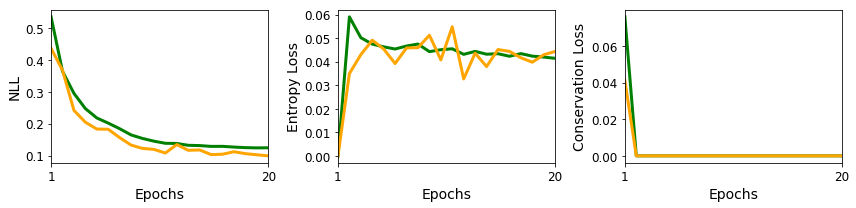

In [36]:

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 4, 3))

n_epochs_actual = len(train_history.history['nll_loss'])

ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['nll_loss'], linewidth=3, color='green')
ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_nll_loss'], linewidth=3, color='orange')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['entropy_loss'], linewidth=3, color='green')
ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_entropy_loss'], linewidth=3, color='orange')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax3.plot(np.arange(1, n_epochs_actual + 1), train_history.history['conservation_loss'], linewidth=3, color='green')
ax3.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_conservation_loss'], linewidth=3, color='orange')

plt.sca(ax3)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Conservation Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


In [37]:
# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler_model.save(model_path)
print('Saved scrambler model at %s ' % (model_path))


Saved scrambler model at saved_models/autoscrambler_dataset_coiled_coil_binders_inverted_scores_sample_mode_gumbel_n_samples_32_resnet_5_4_48_3_00_n_epochs_20_target_lum_01_kl_divergence_zeropad_joint_2_with_label_gumbel_no_bg_lum.h5 


In [38]:
#Load models
save_dir = 'saved_models'

#model_name = "autoscrambler_dataset_coiled_coil_binders_inverted_scores_sample_mode_st_n_samples_32_resnet_5_4_48_3_00_n_epochs_20_target_bits_24_kl_divergence_log_prob"

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')
scrambler_model = load_model(model_path, custom_objects={
    'sample_mask_gumbel' : sample_mask_gumbel,
    'seq_length' : seq_length
})

print('Loaded scrambler model %s ' % (model_path))


Loaded scrambler model saved_models/autoscrambler_dataset_coiled_coil_binders_inverted_scores_sample_mode_gumbel_n_samples_32_resnet_5_4_48_3_00_n_epochs_20_target_lum_01_kl_divergence_zeropad_joint_2_with_label_gumbel_no_bg_lum.h5 


Test sequence 0:


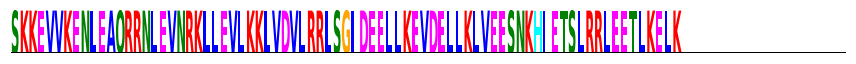

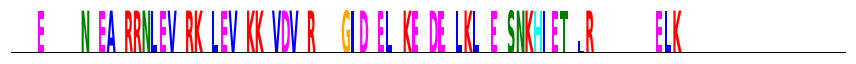

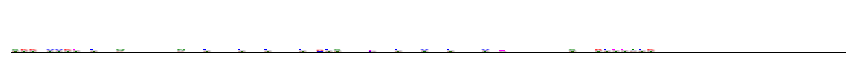

Test sequence 1:


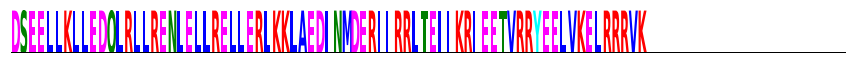

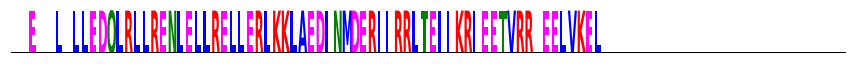

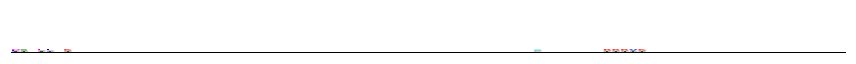

Test sequence 2:


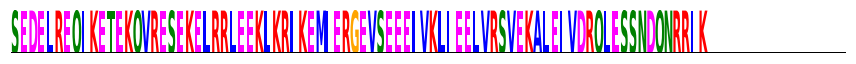

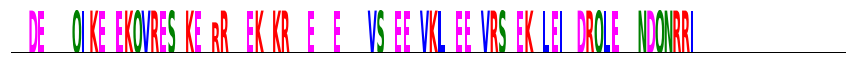

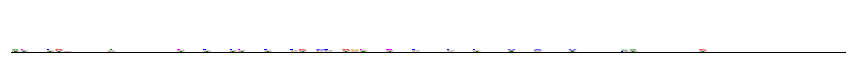

Test sequence 3:


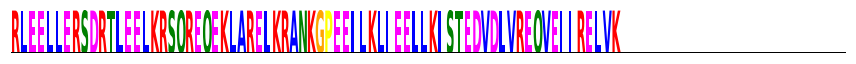

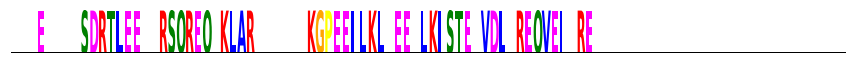

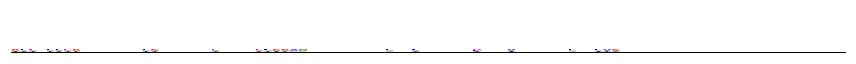

Test sequence 4:


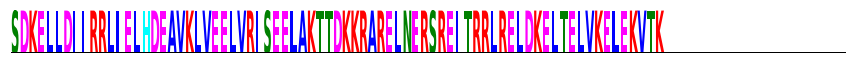

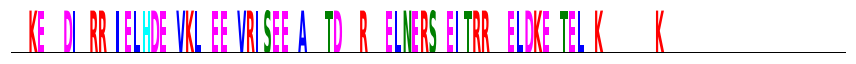

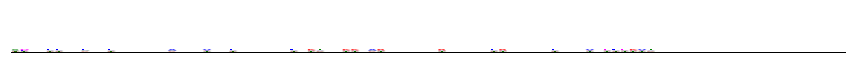

In [39]:
#Visualize a few reconstructed sequence patterns

pwm_test, importance_scores, _, _ = scrambler_model.predict_on_batch(x=[x_1_test[:32], l_1_test[:32], x_2_test[:32], l_2_test[:32], y_test[:32]])

subtracted_logits_test = (2. * np.array(x_1_test[:32], dtype=np.float64) - 1.) * np.maximum(np.array(importance_scores, dtype=np.float64), 1e-7)
subtracted_pwm_test = np.exp(subtracted_logits_test) / np.expand_dims(np.sum(np.exp(subtracted_logits_test), axis=-1), axis=-1)

for plot_i in range(0, 5) :
    
    print("Test sequence " + str(plot_i) + ":")
    
    plot_protein_logo(residue_map, x_1_test[plot_i, 0, :, :], sequence_template=sequence_templates[l_1_test[plot_i, 0]], figsize=(12, 1), plot_start=0, plot_end=96)
    plot_protein_logo(residue_map, pwm_test[plot_i, 0, :, :], sequence_template=sequence_templates[l_1_test[plot_i, 0]], figsize=(12, 1), plot_start=0, plot_end=96)
    plot_protein_logo(residue_map, subtracted_pwm_test[plot_i, 0, :, :], sequence_template=sequence_templates[l_1_test[plot_i, 0]], figsize=(12, 1), plot_start=0, plot_end=96)


In [40]:
#Binder DHD_154

#seq_1 = ("TAEELLEVHKKSDRVTKEHLRVSEEILKVVEVLTRGEVSSEVLKRVLRKLEELTDKLRRVTEEQRRVVEKLN" + "#" * seq_length)[:81]
#seq_2 = ("DLEDLLRRLRRLVDEQRRLVEELERVSRRLEKAVRDNEDERELARLSREHSDIQDKHDKLAREILEVLKRLLERTE" + "#" * seq_length)[:81]
seq_1 = "TAEELLEVHKKSDRVTKEHLRVSEEILKVVEVLTRGEVSSEVLKRVLRKLEELTDKLRRVTEEQRRVVEKLN"[:81]
seq_2 = "DLEDLLRRLRRLVDEQRRLVEELERVSRRLEKAVRDNEDERELARLSREHSDIQDKHDKLAREILEVLKRLLERTE"[:81]

print("Seq 1 = " + seq_1)
print("Seq 2 = " + seq_2)

encoder = IdentityEncoder(81, residue_map)

test_onehot_1 = np.tile(np.expand_dims(np.expand_dims(encoder(seq_1), axis=0), axis=0), (batch_size, 1, 1, 1))
test_onehot_2 = np.tile(np.expand_dims(np.expand_dims(encoder(seq_2), axis=0), axis=0), (batch_size, 1, 1, 1))

test_len_1 = np.tile(np.array([[len(seq_1)]]), (batch_size, 1))
test_len_2 = np.tile(np.array([[len(seq_2)]]), (batch_size, 1))

pred_interacts = predictor.predict(x=[test_onehot_1[:, 0, ...], test_onehot_2[:, 0, ...]])[0, 0]

print("Predicted interaction prob = " + str(round(pred_interacts, 4)))


Seq 1 = TAEELLEVHKKSDRVTKEHLRVSEEILKVVEVLTRGEVSSEVLKRVLRKLEELTDKLRRVTEEQRRVVEKLN
Seq 2 = DLEDLLRRLRRLVDEQRRLVEELERVSRRLEKAVRDNEDERELARLSREHSDIQDKHDKLAREILEVLKRLLERTE
Predicted interaction prob = 0.8533


Scrambler predictions = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Binder 1:


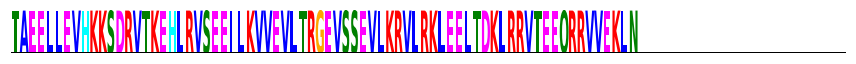

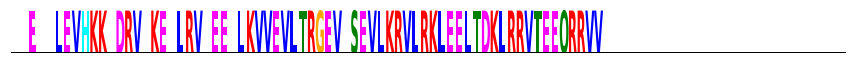

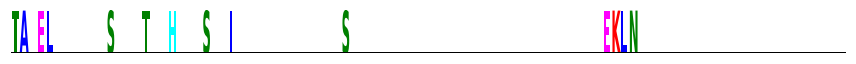

Binder 2:


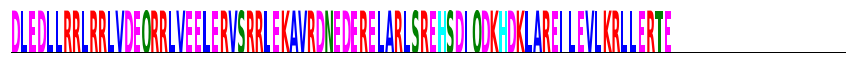

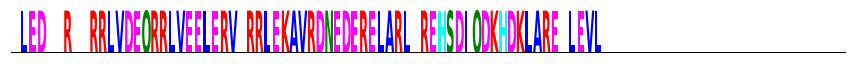

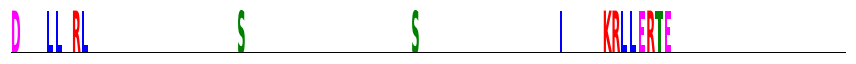

In [41]:
#Visualize a few reconstructed sequence patterns

save_figs = True

pair_name = "DHD_154"

pwm_test_1, importance_scores_1, pwm_test_2, importance_scores_2 = scrambler_model.predict_on_batch(x=[test_onehot_1, test_len_1, test_onehot_2, test_len_2, np.ones((batch_size, 1))])

scrambled_pred_interacts = predictor.predict(x=[pwm_test_1[:, 0, ...], pwm_test_2[:, 0, ...]])[:, 0]

print("Scrambler predictions = " + str(np.round(scrambled_pred_interacts[:10], 2)))

subtracted_pwm_test_1 = test_onehot_1 * importance_scores_1
subtracted_pwm_test_2 = test_onehot_2 * importance_scores_2

print("Binder 1:")

plot_protein_logo(residue_map, test_onehot_1[0, 0, :, :], sequence_template=sequence_templates[test_len_1[0, 0]], figsize=(12, 1), plot_start=0, plot_end=96, save_figs=save_figs, fig_name=model_name + "_original_example_" + pair_name + "_binder_1")
plot_protein_logo(residue_map, pwm_test_1[0, 0, :, :], sequence_template=sequence_templates[test_len_1[0, 0]], figsize=(12, 1), plot_start=0, plot_end=96, save_figs=save_figs, fig_name=model_name + "_scrambled_example_" + pair_name + "_binder_1")
plot_protein_logo(residue_map, subtracted_pwm_test_1[0, 0, :, :], sequence_template=sequence_templates[test_len_1[0, 0]], figsize=(12, 1), plot_start=0, plot_end=96, save_figs=save_figs, fig_name=model_name + "_subtracted_example_" + pair_name + "_binder_1")

print("Binder 2:")

plot_protein_logo(residue_map, test_onehot_2[0, 0, :, :], sequence_template=sequence_templates[test_len_2[0, 0]], figsize=(12, 1), plot_start=0, plot_end=96, save_figs=save_figs, fig_name=model_name + "_original_example_" + pair_name + "_binder_2")
plot_protein_logo(residue_map, pwm_test_2[0, 0, :, :], sequence_template=sequence_templates[test_len_2[0, 0]], figsize=(12, 1), plot_start=0, plot_end=96, save_figs=save_figs, fig_name=model_name + "_scrambled_example_" + pair_name + "_binder_2")
plot_protein_logo(residue_map, subtracted_pwm_test_2[0, 0, :, :], sequence_template=sequence_templates[test_len_2[0, 0]], figsize=(12, 1), plot_start=0, plot_end=96, save_figs=save_figs, fig_name=model_name + "_subtracted_example_" + pair_name + "_binder_2")


In [42]:
#Re-load cached dataframe (shuffled)

dataset_name = "coiled_coil_binders"

experiment = "coiled_coil_binders_alyssa"

data_df = pd.read_csv(experiment + ".csv", sep="\t")

print("len(data_df) = " + str(len(data_df)))

test_df = data_df.copy().reset_index(drop=True)

batch_size = 32
test_df = test_df.iloc[:(len(test_df) // batch_size) * batch_size].copy().reset_index(drop=True)

print("len(test_df) = " + str(len(test_df)))

print(test_df.head())


len(data_df) = 481
len(test_df) = 480
                                        monomer_id_1  \
0  redesigned_closed_5_7_9_9middlesbobby_1_1_S_39...   
1  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_08...   
3  redesigned_closed_5_6_9_10middlesscott_1_1_S_3...   
4  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   

                                        monomer_id_2  \
0  redesigned_closed_5_7_9_9middlesbobby_1_1_S_39...   
1  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_08...   
3  redesigned_closed_5_6_9_10middlesscott_1_1_S_3...   
4  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   

                                         amino_seq_1  \
0  DEEELLKLIEDLLKSNKELLDLSKKNLRLLRELVRERNMDDTALRK...   
1  SEKELLELLRELIEDLDRDVKLLRRNVDLHRRVAREGMREELIKKS...   
2  SEEERITEIVKRVEELLRRYEELVKEYKRVLEELRRELREEEQKEL...   
3  SDEEELDEIIKRSEEVMREVEEIDKRVEDIVRKAAKEGASELVKRS...   
4  TVKEL

In [43]:
#Construct test data

batch_size = 32

test_gen = iso.DataGenerator(
    np.arange(len(test_df), dtype=np.int),
    { 'df' : test_df },
    batch_size=(len(test_df) // batch_size) * batch_size,
    inputs = [
        {
            'id' : 'amino_seq_1',
            'source_type' : 'dataframe',
            'source' : 'df',
            #'extractor' : lambda row, index: (row['amino_seq_1'] + "#" * seq_length)[:seq_length],
            'extractor' : lambda row, index: row['amino_seq_1'],
            'encoder' : IdentityEncoder(seq_length, residue_map),
            'dim' : (1, seq_length, len(residue_map)),
            'sparsify' : False
        },
        {
            'id' : 'amino_seq_2',
            'source_type' : 'dataframe',
            'source' : 'df',
            #'extractor' : lambda row, index: row['amino_seq_2'] + "#" * seq_length)[:seq_length],
            'extractor' : lambda row, index: row['amino_seq_2'],
            'encoder' : IdentityEncoder(seq_length, residue_map),
            'dim' : (1, seq_length, len(residue_map)),
            'sparsify' : False
        },
        {
            'id' : 'amino_seq_1_len',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: len(row['amino_seq_1']),
            'encoder' : lambda t: t,
            'dim' : (1,),
            'sparsify' : False
        },
        {
            'id' : 'amino_seq_2_len',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: len(row['amino_seq_2']),
            'encoder' : lambda t: t,
            'dim' : (1,),
            'sparsify' : False
        }
    ],
    outputs = [
        {
            'id' : 'interacts',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: row['interacts'],
            'transformer' : NopTransformer(1),
            'dim' : (1,),
            'sparsify' : False
        }
    ],
    randomizers = [],
    shuffle = False
)

#Load data matrices

[x_1_test, x_2_test, l_1_test, l_2_test], [y_test] = test_gen[0]

print("x_1_test.shape = " + str(x_1_test.shape))
print("x_2_test.shape = " + str(x_2_test.shape))
print("l_1_test.shape = " + str(l_1_test.shape))
print("l_2_test.shape = " + str(l_2_test.shape))

print("y_test.shape = " + str(y_test.shape))


x_1_test.shape = (480, 1, 81, 20)
x_2_test.shape = (480, 1, 81, 20)
l_1_test.shape = (480, 1)
l_2_test.shape = (480, 1)
y_test.shape = (480, 1)


In [44]:
#Predict on test set

pwm_test_1, importance_scores_1, pwm_test_2, importance_scores_2 = scrambler_model.predict(x=[x_1_test, l_1_test, x_2_test, l_2_test, y_test], batch_size=32, verbose=True)

unscrambled_preds = predictor.predict(x=[x_1_test[:, 0, ...], x_2_test[:, 0, ...]], batch_size=32, verbose=True)[:, 0]

scrambled_preds = []
for i in range(pwm_test_1.shape[0]) :
    if i % 100 == 0 :
        print("Predicting scrambled samples for sequence " + str(i) + "...")
    
    scrambled_pred_sample = predictor.predict(x=[pwm_test_1[i, ...], pwm_test_2[i, ...]], batch_size=32, verbose=False)[0, 0]
    scrambled_preds.append(scrambled_pred_sample)

scrambled_preds = np.array(scrambled_preds)


480/480 [==============================] - 0s 456us/step
Predicting scrambled samples for sequence 0...
Predicting scrambled samples for sequence 100...
Predicting scrambled samples for sequence 200...
Predicting scrambled samples for sequence 300...
Predicting scrambled samples for sequence 400...


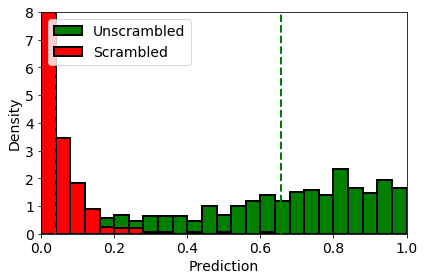

In [45]:

min_val = 0.0
max_val = 1.0

max_y_val = 8

n_bins = 25

save_figs = True

figsize = (6, 4)

measurements = [
    unscrambled_preds,
    scrambled_preds
]

colors = [
    'green',
    'red'
]

labels = [
    'Unscrambled',
    'Scrambled'
]

x_label = 'Prediction'
y_label = 'Density'

min_hist_val = np.min(measurements[0])
max_hist_val = np.max(measurements[0])
for i in range(1, len(measurements)) :
    min_hist_val = min(min_hist_val, np.min(measurements[i]))
    max_hist_val = max(max_hist_val, np.max(measurements[i]))

if min_val is not None :
    min_hist_val = min_val
if max_val is not None :
    max_hist_val = max_val

hists = []
bin_edges = []
means = []
for i in range(len(measurements)) :
    hist, b_edges = np.histogram(measurements[i], range=(min_hist_val, max_hist_val), bins=n_bins, density=True)

    hists.append(hist)
    bin_edges.append(b_edges)
    means.append(np.mean(measurements[i]))

bin_width = bin_edges[0][1] - bin_edges[0][0]


#Compare Log Likelihoods
f = plt.figure(figsize=figsize)

for i in range(len(measurements)) :
    plt.bar(bin_edges[i][1:] - bin_width/2., hists[i], width=bin_width, linewidth=2, edgecolor='black', color=colors[i], label=labels[i])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(min_hist_val, max_hist_val)
if max_y_val is not None :
    plt.ylim(0, max_y_val)

plt.xlabel(x_label, fontsize=14)
plt.ylabel(y_label, fontsize=14)

for i in range(len(measurements)) :
    plt.axvline(x=means[i], linewidth=2, color=colors[i], linestyle="--")

plt.legend(fontsize=14, loc='upper left')

plt.tight_layout()

if save_figs :
    
    fig_name = experiment + "_model_" + model_name + "_pos_hist"
    
    plt.savefig(fig_name + ".png", dpi=300, transparent=True)
    plt.savefig(fig_name + ".eps")

plt.show()


In [46]:
#Store unscrambled and scrambled binding predictions

test_df['pred_interacts'] = np.round(unscrambled_preds, 2)
test_df['pred_interacts_scrambled'] = np.round(scrambled_preds, 2)

flat_importance_scores_1 = importance_scores_1[:, 0, :, 0]
flat_importance_scores_2 = importance_scores_2[:, 0, :, 0]

short_model_name = "target_lum_" + str(entropy_target_lum[0]).replace(".", "") + "_epochs_" + str(n_epochs) + experiment_suffix

test_df.to_csv(experiment + "_model_" + short_model_name + "_testset.csv", sep="\t", index=False)

np.save(experiment + "_model_" + short_model_name + "_testset_importance_scores_1", flat_importance_scores_1)
np.save(experiment + "_model_" + short_model_name + "_testset_importance_scores_2", flat_importance_scores_2)
